# Data Visualization

Visual analysis of hydro-geological datasets for Germany

unique datasets: 
-   bergbaugebiete_v1_poly
-   gwerg_erg_v11_poly
-   gwerg_gestein_v1_poly
-   gwerg__v11_poly
-   uferfiltrat_v1_poly
-   uferfiltrat_v1_line

Contents 

[​Groundwater sources and mining areas](#groundwater-sources-and-mining-areas)

[​Choropleth map for rock types](#choropleth-map-for-rock-types)

[Histogram of groundwater extraction rates](#histogram-of-groundwater-extraction-rates)

[Insights](#insights)

In [1]:
# Import necessary packages
from dbfread import DBF
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import os
import pandas as pd
from pyhere import here
import seaborn as sns


In [2]:
# datasets not provided as csvs. 
# screen folder for .dbf, .shp, files, load as (geo)pandas dfs, save (g)dfs in dicts with filenames as keys
# for plotting, transform to geographical crs 
dfs = {}
gdfs = {}
folder_path = here("ERGW1000/ERGW1000_v1/shp")
for file in os.listdir(folder_path):
    if file.endswith(".dbf"):
        # create short filename
        filename = file.replace("ergw1000_", "").replace(".dbf", "")
        path_to_file = os.path.join(folder_path, file)
        table = DBF(path_to_file, load=True,  encoding="utf-8")
        #convert to pandas df
        df = pd.DataFrame(iter(table))
        #save to dict
        dfs[filename] = df
    if file.endswith(".shp"):
        # create short filename
        filename = file.replace("ergw1000_", "").replace(".shp", "")
        path_to_shapefile = os.path.join(folder_path, file)
        gdf = gpd.read_file(path_to_shapefile)
        gdf = gdf.to_crs(epsg=4326)
        #save to dict
        gdfs[filename] = gdf


### Groundwater sources and mining areas

In [3]:
# mining data: add id to identify mining regions
mining_gdf = gdfs['bergbaugebiete__v1_poly'].reset_index(names='mining_id')
# groundwater data: filter only for "Bedeutende Grundwasservorkommen" (relevant groundwater storage), corresponding to 'erg_id' 11,12,13
water_gdf = gdfs['gwerg_erg_v11_poly']
water_gdf= water_gdf[water_gdf["erg_id"].isin([11,12,13])]

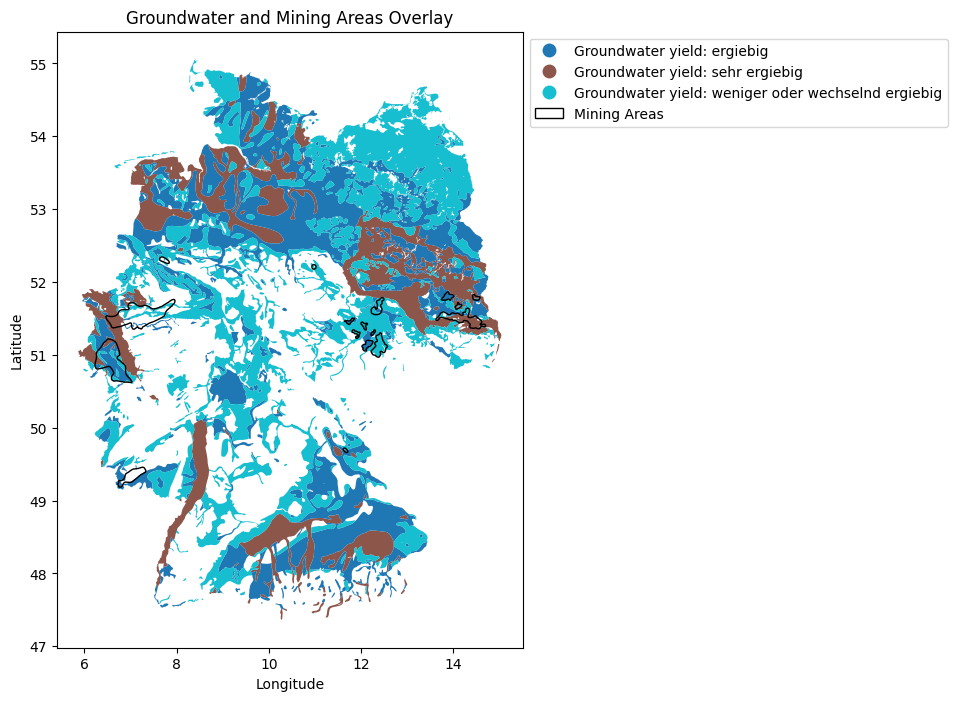

In [4]:
fig, ax = plt.subplots(figsize=(10, 8))


# Plot groundwater areas 
water_gdf.plot(ax=ax, column='ergiebigke', legend=True)

# Overlay mining areas
mining_gdf.plot(ax=ax, facecolor="none", edgecolor="black", label="Mining Areas", legend=True)

plt.title("Groundwater and Mining Areas Overlay")
plt.xlabel("Longitude")
plt.ylabel("Latitude")


# Get existing legend from groundwater plot
legend = ax.get_legend()

# Manually add mining areas to the legend
mining_patch = mpatches.Patch(edgecolor='black', facecolor='none', label="Mining Areas")

# Create new legend with both groundwater and mining areas
handles, labels = legend.legend_handles, [t.get_text() for t in legend.texts]
labels = [f"Groundwater yield: {value}" for value in labels]
handles.append(mining_patch)
labels.append("Mining Areas")

ax.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(1, 1), ncol=1, frameon=True)

plt.savefig(here("plots/groundwater_mining_areas.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

### Choropleth map for rock types

In [5]:
geo_gdf = gdfs['gwerg_gestein_v1_poly']
# remove missing rocktype (gestein) information
geo_gdf = geo_gdf.dropna() 

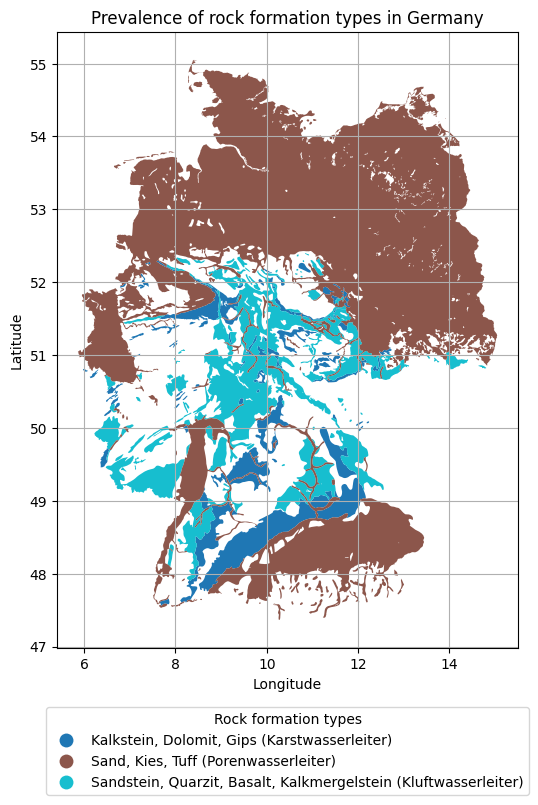

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))

geo_gdf.plot(ax = ax,
             column = 'gestein', 
             legend=True, 
             legend_kwds={"loc": "lower center", 
                          "bbox_to_anchor": (0.5, -0.25), 
                          "title": "Rock formation types", 
                          
                          }
                          )
plt.title("Prevalence of rock formation types in Germany")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.savefig(here("plots/rock_formation_types.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

### Histogram of groundwater extraction rates

In [7]:
water_geo_gdf = gdfs['gwerg__v11_poly']
# filter for relevant sources only
water_geo_gdf = water_geo_gdf.loc[water_geo_gdf['erg_id'].isin([11,12,13])]

In [8]:
# make dict to map entn_bru to numerical values
water_geo_gdf['entn_bru'].unique()

array(['meist 5 - 15 (l/s)', 'meist > 40 (l/s)', 'meist 15 - 40 (l/s)'],
      dtype=object)

In [9]:
ent_bru_dict = {'meist 5 - 15 (l/s)': 1,  'meist 15 - 40 (l/s)': 2, 'meist > 40 (l/s)': 3}
ent_bru_id = water_geo_gdf['entn_bru'].map(ent_bru_dict)

In [10]:
gestein = water_geo_gdf['gestein'].fillna("Not applicable")

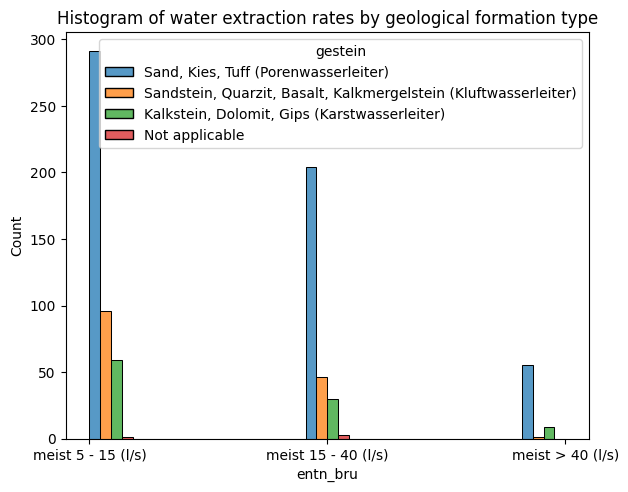

In [11]:
sns.histplot(water_geo_gdf, x=ent_bru_id, hue= gestein, multiple='dodge')
plt.xticks(ticks=[1, 2, 3], labels=[i for i in ent_bru_dict.keys()])
plt.tight_layout()
plt.title("Histogram of water extraction rates by geological formation type")
plt.savefig(here("plots/histogram_entn_bru.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

### Insights

- Are there significant overlaps between important groundwater sources and mining areas?

Yes, the mining areas all have some overlap with relevant groundwater carrying regions. 

However, only 2 mining regions overlap with very high yielding groundwater resource areas. 

The share of area overlap was calcuated in the notebook containing the EDA.

- Which geological formations are most common in high-extraction regions?

"Porenwasserleiter", followed by "Karstwasserleiter" are the predominant geological formations in high extraction regions (ent_bru == "meist > 40 (l/s)").